# 1) Produce Daily Power Consumption [CSV]

In [1]:
from google.colab import drive
#mount you GoogleDrive to "drive" folder
drive.mount('/drive', force_remount=True)

Mounted at /drive


In [3]:
path = "/drive/My Drive/bd622/"

In [4]:
# resample minute data to total for each day
from pandas import read_csv
# load the new file
dataset = read_csv(path+'household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# resample data to daily
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()
# summarize
print(daily_data.shape)
print(daily_data.head())
# save
daily_data.to_csv(path+'household_power_consumption_days.csv')

(1442, 8)
            Global_active_power  ...  sub_metering_4
datetime                         ...                
2006-12-16             1209.176  ...    14680.933319
2006-12-17             3390.460  ...    36946.666732
2006-12-18             2203.826  ...    19028.433281
2006-12-19             1666.194  ...    13131.900043
2006-12-20             2225.748  ...    20384.800011

[5 rows x 8 columns]


# 2) Split Dataset into Train & Test

In [5]:
# univariate multi-step lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test
# load the new file
dataset = read_csv(path+'household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 7
print("training:", train.shape)
print("testing:", test.shape)
print(dataset.head(5))


training: (159, 7, 8)
testing: (46, 7, 8)
            Global_active_power  ...  sub_metering_4
datetime                         ...                
2006-12-16             1209.176  ...    14680.933319
2006-12-17             3390.460  ...    36946.666732
2006-12-18             2203.826  ...    19028.433281
2006-12-19             1666.194  ...    13131.900043
2006-12-20             2225.748  ...    20384.800011

[5 rows x 8 columns]


In [6]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM

# 3) Construct Multi-Step Univariate training dataset

In [7]:
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)
train_x, train_y = to_supervised(train, n_input)
print("training [raw]",train.shape)
print("training features [multi-step]",train_x.shape)
print("training outputs [multi-step]",train_y.shape)

training [raw] (159, 7, 8)
training features [multi-step] (1100, 7, 1)
training outputs [multi-step] (1100, 7)


In [8]:
train_y = train_y.reshape((train_y.shape[0],train_y.shape[1],1))

In [9]:
print(train[0,:,0]) #first column is ourt target; active power usage
print(train_x[0])
print(train_y[0])

[3390.46  2203.826 1666.194 2225.748 1716.624 2341.338 4773.386]
[[3390.46 ]
 [2203.826]
 [1666.194]
 [2225.748]
 [1716.624]
 [2341.338]
 [4773.386]]
[[2550.012]
 [2743.12 ]
 [3934.11 ]
 [1528.76 ]
 [2072.638]
 [3174.392]
 [2789.302]]


# 4) Build Encoder-Decoder LSTM Model

In [15]:
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

verbose, epochs, batch_size = 0, 10, 16
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(RepeatVector(n_outputs))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')
# fit network
history=model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)

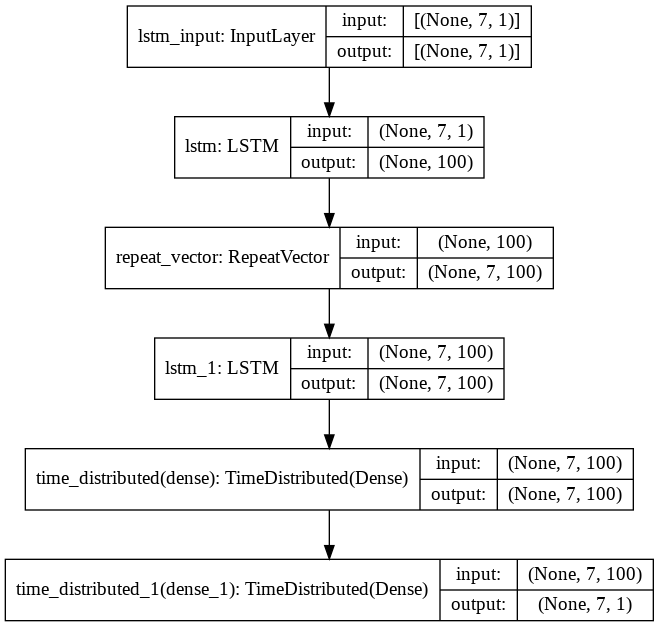

In [16]:
from keras.utils.vis_utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True)

dict_keys(['loss'])


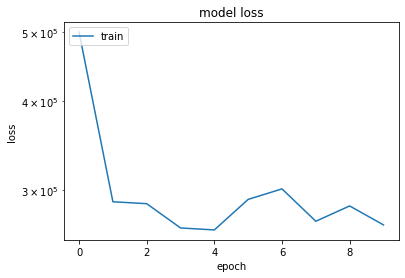

In [17]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 5) Model Evaluation

In [18]:
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	#print(data.shape)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  # retrieve last observations for input data
	input_x = data[-n_input:, 0]
	#print("last obs input_x: ", input_x, " shape: ", input_x.shape)
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	#print("last obs input_x: ", input_x, " shape: ", input_x.shape)
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [19]:
historyX = [x for x in train_x]
data = array(historyX)
yhat_sequence = forecast(model, historyX, n_input)
print("next 7 outputs: ",yhat_sequence)

next 7 outputs:  [[1802.674 ]
 [1873.3949]
 [1862.5103]
 [1849.3654]
 [1860.3035]
 [1871.5002]
 [1882.5225]]


In [20]:
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))


RMSE of LSTM model: [Overall] Sun, ..., Sat : [672.513] 643.3, 665.2, 629.6, 693.3, 678.3, 625.8, 762.2


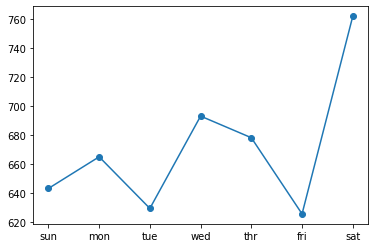

In [21]:
# history is a list of weekly data
historyX = [x for x in train_x]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
  # predict the week
  yhat_sequence = forecast(model, train_x, n_input)
  # store the predictions
  predictions.append(yhat_sequence)
  # get real observation and add to history for predicting the next week
  historyX.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)
# summarize scores
summarize_scores('RMSE of LSTM model: [Overall] Sun, ..., Sat ', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()